# Predicting the Margin-of-Victory for the 2018 House Election

#### Task created and data supplied by Decision Desk HQ, analysis completed by Arianwyn Frank

Our task here, ladies and gentelman, is to predict the margin-of-victory for the winners of the 2018 US House of Representatives election seats. In this notebook I will not only be demonstrating my solution of the problem at hand, but also the trials I endured in order to reach my solution. 

My audience for this is (hopefully) my future employeers so I am going to keep a bit of whimsy within this notebook. However, I want you to know that if I was writing an article to the general public I would be much more formal. Some of my comments going forward are a stylistic choice that is created to entertain you guys, and should not be taken as a representation of an attempt to create a report targeted to the greater public.

## Step 1: Imports

I find it important to do my imports at the beginning so we can avoid periodically doing imports. In my opinion this just makes everything come out more smoothly. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
raw_data = pd.read_csv('DDHQ_Data_Exercise Aug 2023.csv')
final_model_data = pd.read_csv('DDHQ_Data_Exercise Aug 2023.csv')
house_data = pd.read_csv('DDHQ_Data_Exercise Aug 2023.csv')

## Step 2: Understanding and Cleaning Our Data

This is the portion in which we get all of our summary statistics in. We want to understand the correlations between our variables and the structure of our data.

Normally I would explore each column, but the assignment PDF outlines our features for that, so it's unnecessary here. Further, DDHQ was nice enough to give me pretty much squeaky clean data so thanks guys!

In [3]:
#print(raw_data.isnull().sum())

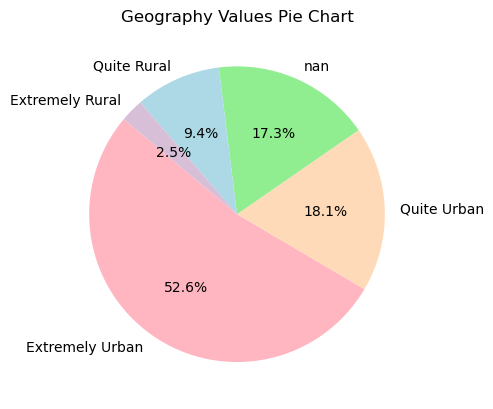

In [4]:
# Defining my typical color palette, I'm a sucker for a good pastel
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

value_counts = raw_data['Geography'].value_counts(dropna=False)
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
plt.title('Geography Values Pie Chart')
plt.show()

In this case, it looks like Geography is missing some columns. However, after reviewing the documentation and chart above, I think it's pretty clear that NaN values are supposed to represent a lack of a leaning rather than a lack of data. Because of this, I think it is best to recode the NaN values to have a more representative label. 

For the record, I do think it is a weak spot in the documentation that it does not specify all of the values that Geography can take on, since there is clearly a unified classification within this feature. Just something to think about. 

In [5]:
# Giving NaN a more indicitive label

raw_data['Geography'].fillna('Neutral', inplace=True)

### Step 2.5: Sorting Features and Encoding

We also need to take a look at our dataset's features. I'm going to start by eliminating chamber because it's the same for all of them. I'm also going to drop the Race ID column because we have all of the information in it stored within Chamber, Year, and State. Lastly, I will encode all of our categorical variables because that's how computers/math works. 

In [6]:
raw_data.drop(columns=['Chamber', 'Race ID'], inplace=True)

filtered_data = raw_data

In [7]:
categorical_vars = ['State', 'Incumbent Running?', 'Geography']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical variable separately
for column in categorical_vars:
    filtered_data[column] = label_encoder.fit_transform(raw_data[column])

## Step 3: Thinking about models

I am going to begin by visualizing the correlations to determine if we have any strongly correlated and/or dependent variables. 

In [8]:
filtered_data['R-D Victory Margin'] = filtered_data['R-D Victory Margin'].replace('???', np.nan)
filtered_data['R-D Victory Margin'] = filtered_data['R-D Victory Margin'].astype(float)
filtered_data.dropna(subset=['R-D Victory Margin'], inplace=True)

In [9]:
correlation_matrix = filtered_data.corr()

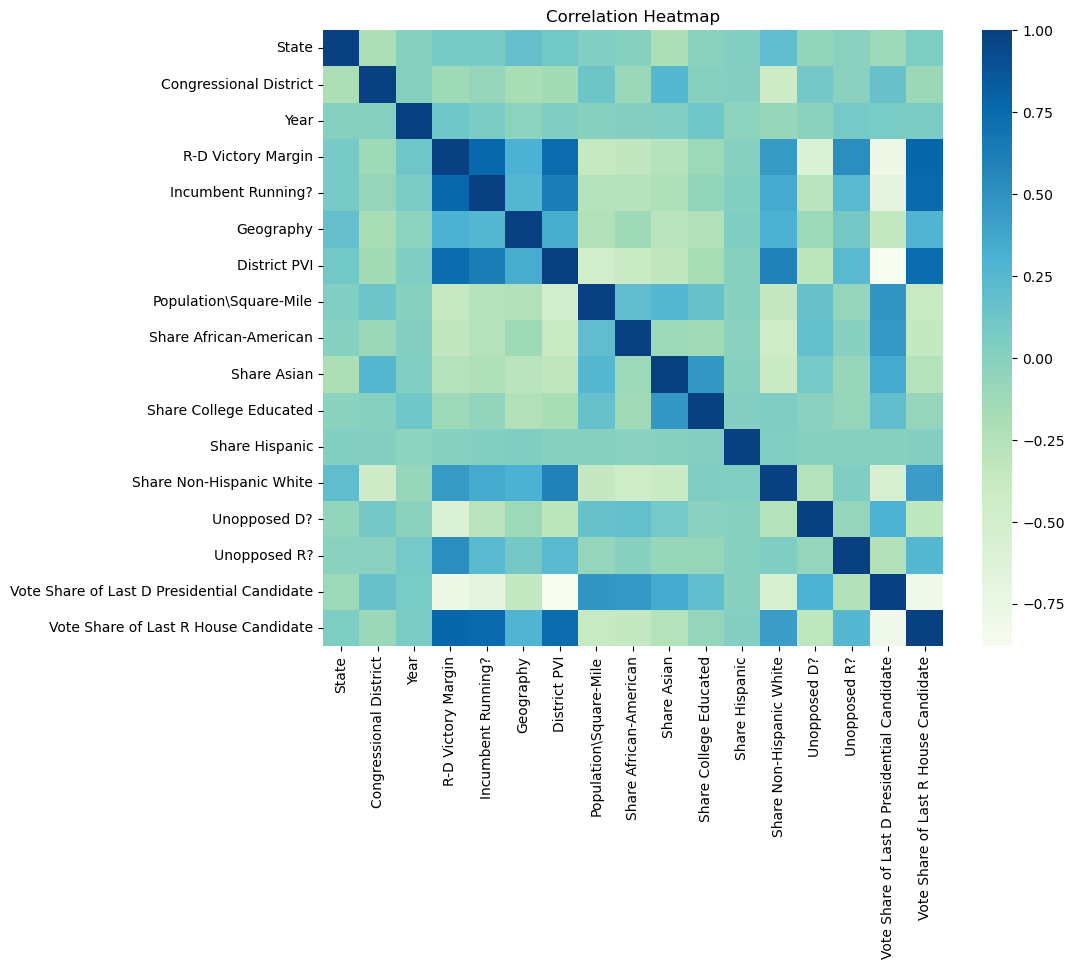

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap="GnBu")
plt.title('Correlation Heatmap')
plt.show()

This heatmap is super telling and highlights my primary concerns. It seems a lot of the variables share correlations, so that's something I'm going to have to watch out before when making my model. I do want to specify that it also makes sense why basically all of these would have a relationship to one another. For example, it makes a lot of sense that R-D Victory Margin be correlated with vote share of last R/D candidate. 

## Step 4: Modeling

It's time to model! In this notebook I plan to keep all iterations of models I have created unless the complexity starts getting really bad, but I do not expect that to be the case. 

In [11]:
filtered_plus_target = filtered_data

X = filtered_data.drop(columns=['R-D Victory Margin'])
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

### Model V1: Linear 

I feel like linear modeling is always the first step to achieving greatness. Just because you don't think the easy version will work doesn't mean you can't try it!

In [12]:
model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

#print(results.summary())

Fun fact I actually have never done specifically statistical modeling in Python, only base level ML with skLearn so please enjoy me getting to do R-style diagnostics in Python for the first time. The future is now.

Anyway my model had an initial R Squared of about 0.92! Honestly for a furst run, I'll take it! However, it is clear from our summary that we have a lot of multicollinearity going on. To do this, I will filter our data further using a recursive method.

### Side mission: filtering our features

#### Filter method 1: Logic!

I want to create a model that only predicts races if they are running opposed. Thus, we can get rid of "Unopposed D" and "Unopposed R" because we can just write an if statement at the beginning of the model. Then, we can also get rid of all of the data in which individuals are running unopposed because we already know their outcome.

In [13]:
filtered_plus_target = filtered_plus_target.drop(filtered_plus_target[filtered_plus_target['Unopposed D?'] == 1].index)
filtered_plus_target = filtered_plus_target.drop(filtered_plus_target[filtered_plus_target['Unopposed R?'] == 1].index)
filtered_plus_target = filtered_plus_target.drop(columns = ['Unopposed D?', 'Unopposed R?'])

filtered_data = filtered_plus_target.drop(columns = ['R-D Victory Margin'])

In [14]:
X = filtered_data
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

#print(results.summary())

#### Filter method 2: Low P Value and Low Error

From our model, I decided to exclude any columns that have a P-Value above 0.05, and any columns that had a relatively large Std. Error. After composing a list of the "problem columns", I funny enough realized that the columns for each elimination category were the exact same.

In [15]:
drop_cols = ['State', 'Congressional District', 'Year', 'Share College Educated', 'Share Hispanic', 'Share Non-Hispanic White']
filtered_data = filtered_data.drop(columns = drop_cols)
filtered_plus_target = filtered_plus_target.drop(columns = drop_cols)

In [16]:
X = filtered_data
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

#print(results.summary())

#### Filter Method 3: Recursive Filtering

It seems we still have some colinearity happening in our dataset. Thus, a great way to eliminate this is with recursive filtering!

In [17]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select = 5)

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Incumbent Running?', 'Share African-American', 'Share Asian',
       'Vote Share of Last D Presidential Candidate',
       'Vote Share of Last R House Candidate'],
      dtype='object')


In [18]:
filtered_data = filtered_data[selected_features]

In [19]:
selected_features = selected_features.append(pd.Index(['R-D Victory Margin']))
filtered_plus_target = filtered_plus_target[selected_features]

X = filtered_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

#print(results.summary())

Now it looks like we are getting somewhere! So far our model only has an R Squared of about 0.83, but the P values, errors, and colinearity all look pretty good. Now that our model is pretty clean, it's time to dive deeper into the data itself. 

### Step 5: Exploring Model Statistics
It seems we still have some colinearity happening in our dataset. Thus, a great way to eliminate this is with recursive filtering!

In [20]:
y_pred = results.predict(X_test_with_intercept)
residuals = y_test - y_pred

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


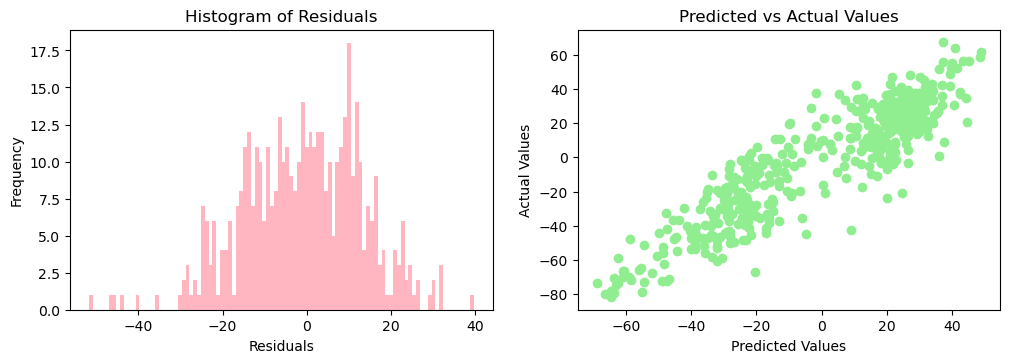

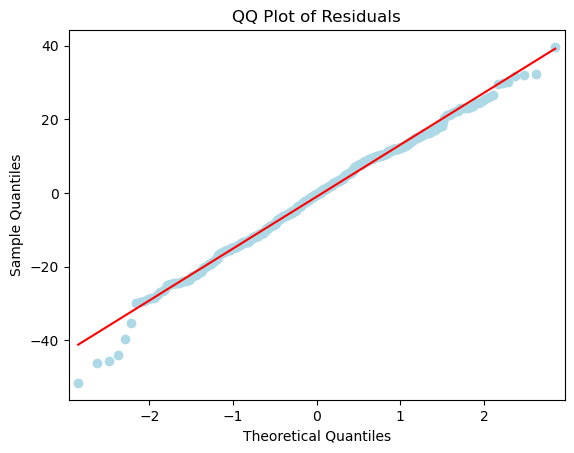

In [21]:
plt.figure(figsize=(12, 8))
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=100, color = '#FFB6C1')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_test, color = '#90EE90')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

sm.qqplot(residuals, line='s', fmt='o', markerfacecolor='#ADD8E6', markeredgecolor='#ADD8E6', color='#D8BFD8')
plt.title('QQ Plot of Residuals')

plt.show()

As you can see from above, our linear model has gotten about as good as we are going to get. Our residual plot and QQ plot evidence demonstrate that our model is homoscedastic and there aren't really any sharp outliers in our data. However, our Predicted vs Actual graph shows us that our model just isn't as accurate as it could be. Thus, I think it is high time that we up the complexity of our model.

### Step 6: Everyone's favorite game: Transform that Data!

I figured now that we have significantly less noise, we should plot our data and see if we should be transforming it. To tell you the truth, I probably should have done this a bit earlier, but better late than never!

In [22]:
y_shifted = y - y.min()
y_log = np.log(y_shifted)

y_boxcox, lambda_value = boxcox(y_shifted + 1)

y_sqrt = np.sqrt(y_shifted)

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


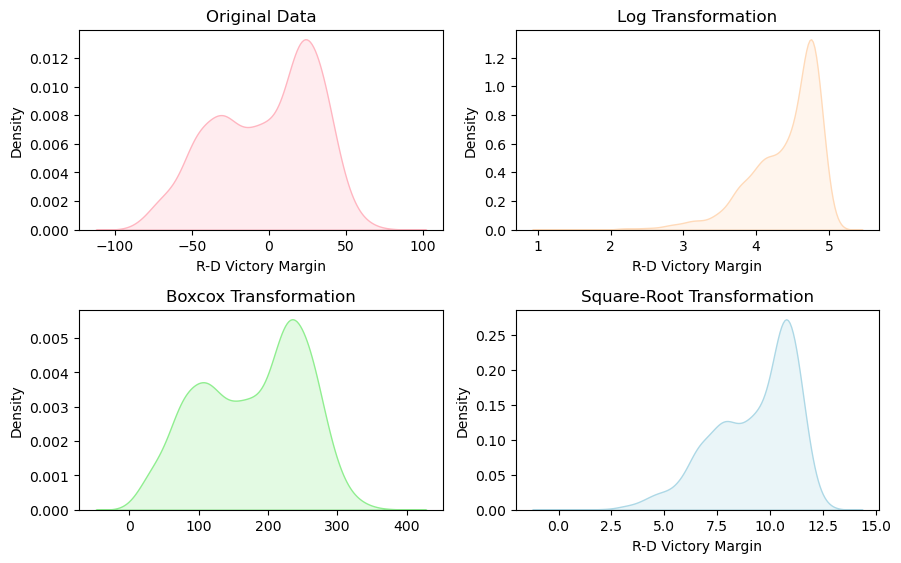

In [23]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.kdeplot(y, shade=True, color='#FFB6C1')
plt.title('Original Data')
plt.ylabel('Density')

plt.subplot(2, 2, 2)
sns.kdeplot(y_log, shade=True, color='#FFDAB9')
plt.title('Log Transformation')
plt.ylabel('Density')

plt.subplot(2, 2, 3)
sns.kdeplot(y_boxcox, shade=True, color='#90EE90')
plt.title('Boxcox Transformation')
plt.ylabel('Density')

plt.subplot(2, 2, 4)
sns.kdeplot(y_sqrt, shade=True, color='#ADD8E6')
plt.title('Square-Root Transformation')
plt.ylabel('Density')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
plt.show()

So it looks like our data gets a little bit more normal with a log transformation, but not much. I'm going to thus attempt to pursue a model with more degrees of freedom!

In [24]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

model = sm.OLS(y_train, X_poly)
results = model.fit()

#print(results.summary())

y_pred = results.predict(X_poly_test)
residuals = y_test - y_pred

final_model = results

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


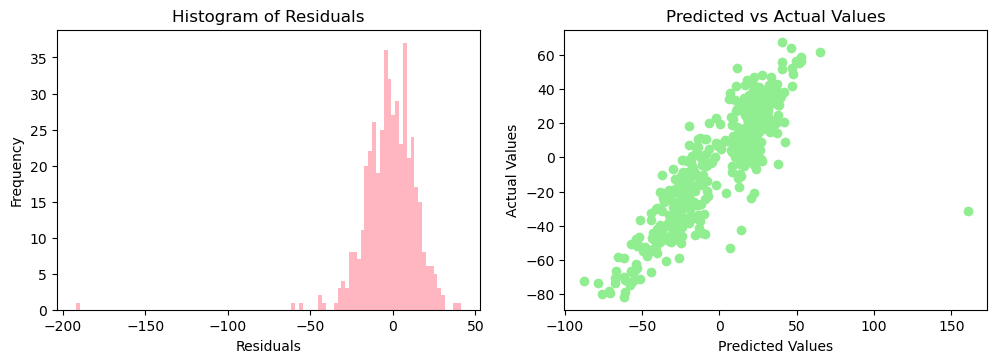

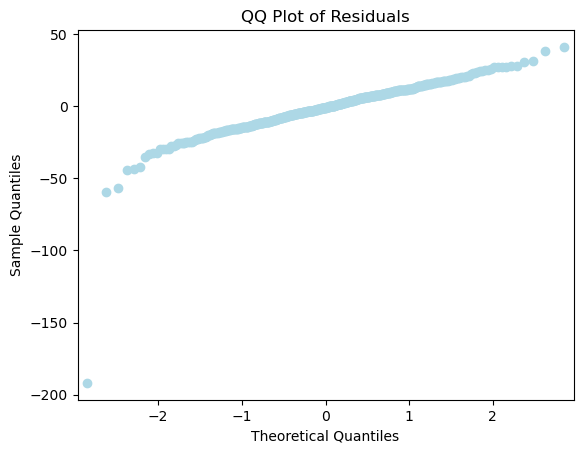

In [25]:
plt.figure(figsize=(12, 8))
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=100, color = '#FFB6C1')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_test, color = '#90EE90')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

sm.qqplot(residuals, markerfacecolor='#ADD8E6', markeredgecolor='#ADD8E6', color='#D8BFD8')
plt.title('QQ Plot of Residuals')

plt.show()

Wow, that looks amazing! Super happy with that model, everything is looking way better than before!

### Step 7: Predict

Using this model, we can now predict the R-D Victory Margin for the "current" House race. I need to encode it and then it should be good to go. 

In [ ]:
def model(house_race_data, final_model):
    data = house_race_data
    
    if data['Unopposed D?'] == 1:
        data['R-D Victory Margin'] = -100
        
    elif data['Unopposed R?'] == 1:
        data['R-D Victory Margin'] = 100
        
    else:
        data['R-D Victory Margin'] = final_model.predict(data)

In [29]:
selected_columns = ['R-D Victory Margin', 'Incumbent Running?', 'Share African-American', 'Share Asian', 'Vote Share of Last D Presidential Candidate', 'Vote Share of Last R House Candidate']
label_encoder = LabelEncoder()

house_data = house_data[selected_columns]
house_data.loc[:, 'Incumbent Running?'] = label_encoder.fit_transform(house_data['Incumbent Running?'])
final_data = house_data[house_data['R-D Victory Margin'] == '???']
final_data = house_data.drop(columns = ['R-D Victory Margin'], inplace = False)
final_data = poly.fit_transform(final_data)

model(final_data, results)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices